In [ ]:
from scipy import ndimage
def vecToCSVLine(vector):
    line = ""
    for i, val in enumerate(vector):
        line += str(val)
        if i < len(vector) - 1:
            line += ", "
    line += "\n"
    return line

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

def oracleTriplet(p1, p2, p3):
    b_1, i1 = p1
    b_2, i2 = p2
    b_3, i3 = p3
    d12 = np.linalg.norm(b_1 - b_2)
    d23 = np.linalg.norm(b_2 - b_3)
    d31 = np.linalg.norm(b_3 - b_1)
    if d12 == min([d12, d23, d31]):
        trip = [i1, i2, i3]
    elif d23 == min([d12, d23, d31]):
        trip = [i2, i3, i1]
    else:
        trip = [i3, i1, i2]
    return trip

def train(ensemble, anchor_img, pos_img, neg_img, transform=True):
    if transform:
        pos_images = np.stack([
            [ndimage.rotate(pos_img, 90)],
            [ndimage.rotate(pos_img, 180)],
            [ndimage.rotate(pos_img, 270)],
        ])
    else:
        pos_images = np.array([[pos_img]])
    anchor_images = np.stack([[anchor_img] for _ in pos_images])
    neg_images = np.stack([[neg_img] for _ in pos_images])
    losses = ensemble.train_batch(anchor_images, pos_images, neg_images)
    return np.array(losses)

def train_batch(ensemble, anchor_batch, pos_batch, neg_batch, transform=True):
    losses = ensemble.train_batch(anchor_batch, pos_batch, neg_batch)
    return np.array(losses)

In [2]:
# import torch
# import os
# import numpy as np
# from data.swarmset import ContinuingDataset, SwarmDataset
# sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
#
# DATA_TEST_SIZE = 1000
# OUT = "data/oracle"
#
# with open(os.path.join(OUT, "triplets.txt"), "x") as f:
#     for i in range(DATA_TEST_SIZE):
#         b = np.random.randint(len(sampled_dataset), size=3)
#         a, p, n = b[0], b[1], b[2]
#         b1, b2, b3 = sampled_dataset[b[0]][2], sampled_dataset[b[1]][2], sampled_dataset[b[2]][2]
#         triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
#         f.write(vecToCSVLine(triplet))

In [2]:
import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=5, output_size=5, lr=5e-4, learning_decay=0.9, decay_step=3)
ensembleA.load_ensemble("Nov21-subzerofive")
ensembleA.trim(3)

sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = [0.6039603960396039]
per_network_acc = [[0.0] for _ in ensembleA.ensemble]
overall_training_average = []


# Get initial Accuracy
# Validation on Oracle Dataset
validation_accuracy = []
OUT = "data/oracle"
with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensembleA.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        network_score += l.detach().cpu()
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

TRIAL_SIZE = 10
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 2000
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    entropy = []
    for i in range(SAMPLES):
        ensembleA.eval_mode()
        h = ensembleA.variance(data[rand_samp[i][0]][0], positive=data[rand_samp[i][1]][0], negative=data[rand_samp[i][2]][0])
        entropy.append((h, i))
    entropy.sort(reverse=True)

    # Query the N most-disagreed upon Triplets
    N = min(SAMPLES, 30)
    for i in range(N):
        # Generate User Triplets
        samp_index = entropy[i][1]
        a, p, n = rand_samp[samp_index]
        b1, b2, b3 = data[a][2], data[p][2], data[n][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        a, n = rand_samp[i][0], rand_samp[i][2]
        pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500
    CONTINUE_PRE = 4
    pretraining_counter = 0
    pretraining_max = 500

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = 6

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < 0.01:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    ensembleA.eval_mode()
    OUT = "data/oracle"
    with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        network_score = np.array([0.0 for _ in ensembleA.ensemble])
        for line in lines:
            triplet = CSVLineToVec(line)
            majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
            network_score += l.cpu().numpy()
            total_score += majority
        acc = total_score / len(lines)
        net_acc = network_score / len(lines)

        for i, net in enumerate(net_acc):
            print(f"Network {i + 1}, Accuracy: {net * 100}%")

        validation_accuracy.append(acc)
        print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

    ensembleA.set_lr(5e-4, 0.9)

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


AttributeError: 'list' object has no attribute 'cpu'

In [10]:
max(lrs)[0]

7.888960739411335e-05

In [ ]:
import time
ensembleA.save_ensemble(f"{int(time.time())}")

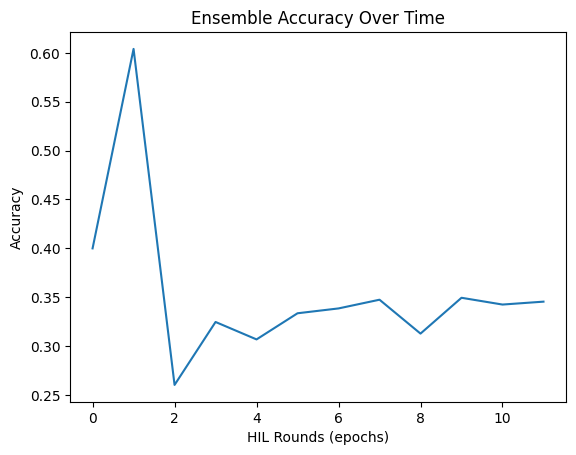

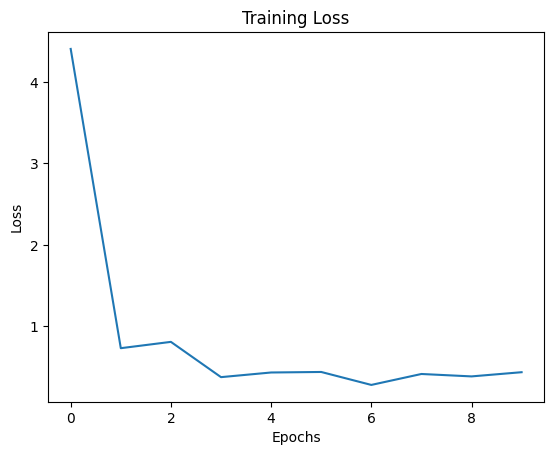

In [32]:
import matplotlib.pyplot as plot
print(validation_accuracy)
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

print(overall_training_average)
plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()

In [ ]:
import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=5, output_size=5, lr=5e-4, learning_decay=0.9, decay_step=3)
ensembleA.load_ensemble("Nov21-subzerofive")
ensembleA.trim(3)

sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = [0.6039603960396039]
overall_training_average = []

# Get initial Accuracy
# Validation on Oracle Dataset
OUT = "data/oracle"
with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    for line in lines:
        triplet = CSVLineToVec(line)
        majority = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        total_score += majority
    acc = total_score / len(lines)
    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc}")

TRIAL_SIZE = 10
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 30
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    # Query the N most-disagreed upon Triplets
    N = min(SAMPLES, 30)
    for i in range(N):
        # Generate User Triplets
        a, p, n = rand_samp[i]
        b1, b2, b3 = data[a][2], data[p][2], data[n][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        a, n = rand_samp[i][0], rand_samp[i][2]
        pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500
    CONTINUE_PRE = 4
    pretraining_counter = 0
    pretraining_max = 1000

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = 6

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < 0.01:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    ensembleA.eval_mode()
    OUT = "data/oracle"
    with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        for line in lines:
            triplet = CSVLineToVec(line)
            majority = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
            total_score += majority
        acc = total_score / len(lines)
        validation_accuracy.append(acc)
        print(f"Validation Complete. Accuracy: {acc}")

    ensembleA.set_lr(5e-4, 0.9)

In [ ]:
import matplotlib.pyplot as plot
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()